# Accounting for Parametric Uncertainty in Hydrological Models

This notebook uses DiffeRential Evolution Adaptive Metropolis (DREAM), a Markov Chain Monte Carlo (MCMC) algorithm, to perform a Bayesian calibration of the ABCD hydrological model, accounting for both parametric uncertainty and model error. We use the version of DREAM in the Probability Inference on Noisy Time Series ([PINTS](https://pints.readthedocs.io/en/latest/)) Python library.

In [ ]:
!pip install numpy==1.25.0 # numpy version compatible with pints
!pip install dataretrieval
!pip install pyncei
!pip install lmoments3
!pip install pints

The code below is from [15_Model_Calibration.ipynb](https://colab.research.google.com/github/StochHydroUVA/CodingExamples/blob/main/15_Model_Calibration.ipynb). It downloads and processes daily flow data for the Rivanna River at Palmyra, and daily precipitation, minimum temperature and maximum temperature at Charlottesville. Then it finds the total monthly precipitation and flow in mm, and the average daily minimum and maximum temperature in degrees C.

In [ ]:
import dataretrieval.nwis as nwis
from pyncei import NCEIBot, NCEIResponse
from datetime import datetime
import pandas as pd
import numpy as np

# download flow data from Rivanna River at Palmyra
flow_df = nwis.get_record(sites='02034000', service='dv', start='2010-10-01', end='2023-09-30') # Rivanna River at Palmyra in cfs

# download precipitation data at Charlottesville (should really use average over basin)
ncei = NCEIBot("klhIxphHLKDrrnjPtJGNpfEnfbERfUvZ")

# loop through each year and append to data frame because you can't download more than 1 year at a time
climate_df = NCEIResponse()
for year in range(2010,2023):
  climate_df.extend(ncei.get_data(
      datasetid="GHCND",
      stationid=["GHCND:USC00441593"],# Charlottesville, VA
      datatypeid=["TMAX", "TMIN", "PRCP"], # degrees Celsius, mm
      startdate=str(year) + "-10-01",
      enddate=str(year+1) + "-09-30",
  )
)

climate_df = climate_df.to_dataframe()

def make_table(table_in, col_str):
  data_table = pd.DataFrame()
  data_table[col_str] = table_in['value'].iloc[np.where(table_in['datatype']==col_str)[0]]
  data_table['date'] = table_in['date'].iloc[np.where(table_in['datatype']==col_str)[0]]
  data_table = data_table.reset_index()
  data_table['date'] = [datetime.strftime(dt, "%Y-%m-%d") for dt in data_table['date']]
  data_table.index = data_table['date']
  data_table = data_table.drop(columns=['date','index'])
  return data_table

data_P = make_table(climate_df, "PRCP")
data_Tmax = make_table(climate_df, "TMAX")
data_Tmin = make_table(climate_df, "TMIN")

data_Q = pd.DataFrame()
data_Q['Q'] = flow_df['00060_Mean']
data_Q['date'] = [datetime.strftime(dt, "%Y-%m-%d") for dt in data_Q.index]
data_Q.index = data_Q['date']
data_Q = data_Q.drop(columns=['date'])

data = data_Q.join(data_P)
data = data.join(data_Tmax)
data = data.join(data_Tmin)
data.interpolate('linear',axis=0,inplace=True)
data.index = pd.to_datetime(data.index)

area = 663*5280**2 # drainage area of Rivanna River at Palmyra in square miles converted to square ft
data['Q'] = data['Q']*3600*24*1000/3.28/area # convert cfs to mm/day

# summarize data into monthly values
monthly_average = data.resample('M').mean()
monthly_sum = data.resample('M').sum()
monthlyData = pd.DataFrame({"PRCP": monthly_sum['PRCP'], "Q": monthly_sum['Q'],
                            "TMAX": monthly_average['TMAX'], "TMIN": monthly_average['TMIN']})
monthlyData

We'll again use the [ABCD Hydrological Model](https://www.researchgate.net/figure/Conceptual-flowchart-of-ABCD-water-balance-model_fig4_368877896) to simulate flow in the Rivanna River at Palmyra. This requires calibrating the parameters a, b, c, and d. The code for this model is provided below.

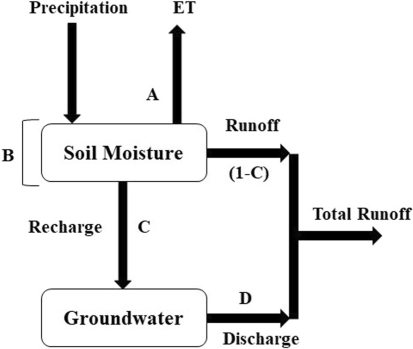

In [ ]:
def abcd(P, Tmax, Tmin, Julian, phi, ndays, params):
  # assign parameters
  a, b, c, d = list(params)
  SM0 = 0
  GS0 = 0

  # estimate average daily temperature as average of Tmin and Tmax (deg C)
  Tavg = (Tmin + Tmin)/2

  # compute PET using Shuttleworth estimation
  d_r = 1 + 0.033*np.cos(2*np.pi*Julian/12) # relative distance between the Earth and the sun
  delta = 0.4093*np.sin(2*np.pi*Julian/12-1.405) # solar declination angle in radians
  omega_s = np.arccos(-np.tan(phi)*np.tan(delta)) # sunset hour angle in radians
  S_0 = 0.6059*d_r*(omega_s*np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta)*np.sin(omega_s)) # water equivalent solar radiation
  PET = 0.0023*25.4*ndays*S_0*np.sqrt((Tmax-Tmin))*(Tavg+17.8) #PET in mm/month

  # create empty vectors to store state variables
  # SM = soil moisture, GS = groundwater storage
  SM, GS = [np.empty([len(P)+1]) for _ in range(2)]
  SM[0] = SM0
  GS[0] = GS0

  # W = total available water content, Y = ET potential, ET = actual ET,
  # DR = direct runoff, GR = groundwater runoff, GD = groundwater discharge
  # Q = streamflow
  W, Y, ET, DR, GR, GD, Q = [np.empty([len(P)]) for _ in range(7)]

  # run model for length of precipitation dataset
  for t in range(1, len(P)):
    W[t] = SM[t] + P[t]
    Y[t] = (W[t]+b) / (2*a) - np.sqrt( ((W[t]+b)/(2*a))**2 - b*W[t]/a )
    SM[t+1] = Y[t] * np.exp(-PET[t]/b)
    ET[t] = Y[t] * (1 - np.exp(-PET[t]/b))
    DR[t] = (1-c) * (W[t] - Y[t])
    GR[t] = c*(W[t] - Y[t])
    GS[t+1] = (1/(1+d)) * (GS[t] + GR[t])
    GD[t] = GS[t] + GR[t] - GS[t+1]
    Q[t] = DR[t] + GD[t]

  return PET, SM, W, Y, ET, DR, GR, GS, GD, Q

Now we'll use DREAM to calibrate the model accounting for parametric uncertainty. This requires defining a likelihood function. We saw in [15_Model_Calibration.ipynb](https://colab.research.google.com/github/StochHydroUVA/CodingExamples/blob/main/15_Model_Calibration.ipynb) that after removing auto-correlation in the log-space residuals of the ABCD model ($\epsilon$) with an AR1 model, the residuals of the AR1 model ($\omega$) are normally distributed. So we'll try to find parameters that maximize the likelihood of the residuals of the AR1 model coming from a normal distribution. These parameters include the a, b, c, d hydrological model parameters as well as the intercept ($\theta_0$), AR1 coefficient ($\theta_1$), and variance ($\sigma^2$) of the residuals of the AR1 model:

$\ln(Qobs_t) = \ln(Qsim_t) + \epsilon_t$  
$\epsilon_t = \theta_0 + \theta_1 \epsilon_{t-1} + \omega_t$  
$\omega_t \sim N(0,\sigma^2)$  

where $Qobs_t$ and $Qsim_t$ are the observed and simulated flow at time $t$, respectively.

In [ ]:
import scipy.stats as ss

def logLikelihood(params):
  # the first 6 parameters are the HYMOD parameters
  # the last 3 parameters are 1) the intercept and
  # 2) the lag-1 coefficient of the AR1 model of the log-space ABCD residuals,
  # and 3) the variance of the residuals of the AR1 model
  modelParams = params[:-3]
  discrepancyParams = params[-3:]
  theta0 = discrepancyParams[0]
  theta1 = discrepancyParams[1]
  sigma2 = discrepancyParams[2]

  # run model with params
  PET, SM, W, Y, ET, DR, GR, GS, GD, Qsim = abcd(monthlyData['PRCP'].array, monthlyData['TMAX'].array, monthlyData['TMIN'].array,
                                                 Julian, phi, ndays, modelParams)

  # get log-space residuals of ABCD model
  ABCDresid = np.log(monthlyData['Q'].array[firstIndex:]) - np.log(Qsim[firstIndex:])

  # get residuals of AR1 model of ABCD residuals
  AR1fitted = theta0 + theta1*ABCDresid
  AR1resid = ABCDresid[1::] - AR1fitted[0:-1]

  # get log-likelihood of residuals being normal
  logL = ss.norm.logpdf(AR1resid, loc=0, scale=np.sqrt(sigma2))

  return np.sum(logL)

Next we have to create a subclass of $\texttt{pints.LogPDF}$ that calls the above likelihood function. We'll call this class $\texttt{ResidLogPDF}$.

In [ ]:
import pints

class ResidLogPDF(pints.LogPDF):
  def __init__(self, nparams):
    self.nparams = nparams

  def n_parameters(self):
    return self.nparams

  def __call__(self, params):
    return logLikelihood(params)

Running DREAM requires an initial parameter estimate for each chain. Let's use the initial parameter estimates for the ABCD model that we used in the previous notebook to find initial parameter estimates for the likelihood parameters. We'll use this for one chain and generate random samples for the other chains (we'll run three chains total).

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

phi = 37.8579192*np.pi/180.0 # latitude of Palmyra in radians (should really use latitude at centroid of basin)
Julian = monthlyData.index.month
ndays = monthlyData.index.days_in_month.array
firstIndex = 12 # first index to use for calibration

# calibration parameters
a = 0.99 # controls the amount of runoff and recharge that occurs when the soils are under-saturated
b = 700 # controls controls the saturation level of the soils
c = 0.3 # defines the ratio of groundwater recharge to surface runoff
d = 0.8 # controls the rate of groundwater discharge
params = [a, b, c, d]

PET, SM, W, Y, ET, DR, GR, GS, GD, Qsim = abcd(monthlyData['PRCP'].array, monthlyData['TMAX'].array, monthlyData['TMIN'].array,
                                               Julian, phi, ndays, params)
logResid = np.log(Qsim[12::]) - np.log(monthlyData['Q'].iloc[12::].array)
logAR1model = AutoReg(np.array(logResid), lags=1)
logAR1result = logAR1model.fit()

# get initial parameter estimates for likelihood function
theta0 = logAR1result.params[0]
theta1 = logAR1result.params[1]
sigma2 = np.var(logAR1result.resid)
discrepancyParams = [theta0, theta1, sigma2]
params = params + discrepancyParams
print("Initial parameter estimates for [a, b, c, d, theta0, theta1, sigma^2]:\n", params)

Finally, we have to specify the priors on each parameter. We'll use the same ranges for a, b, c, and d as in the prior notebook. For $\theta_0$, $\theta_1$ and $\sigma^2$, I've used +/-0.6, corresponding to about 20\% of the mean log-space flow (i.e. about +/- 20\% bias), [0,1] for uncorrelated to perfectly positively correlated residuals, and a standard deviation of the residuals between 0 and about 50\% of the mean log-space flow.

I initialize the first chain with the above parameter estimates and randomly generate initial points from the prior distribution for the other two parameters.

In [ ]:
# specify lower and upper bounds of uniform priors on each parameter
log_prior = pints.UniformLogPrior(
    [0.001, 0.1, 0, 0, -0.6, 0, 0],
    [1, 2000, 1, 1, 0.6, 1, 2.5]
)

# generate initial samples for each of 3 chains
np.random.seed(1)
x0 = [params, log_prior.sample(1)[0], log_prior.sample(1)[0]]
nchains=3

# specify posterior by passing likelihood and prior
log_posterior = pints.LogPosterior(ResidLogPDF(len(params)), log_prior)

# choose solver, specify burn-in and iterations after burn-in
mcmc = pints.MCMCController(log_posterior, nchains, x0, method=pints.DreamMCMC)
mcmc.set_initial_phase_iterations(500)
mcmc.set_max_iterations(10000)

# run MCMC (don't print results)
mcmc.set_log_to_screen(False)
chains = mcmc.run()

Let's investigate the trace plots to see if the chains are well-mixed and converging to similar marginal posteriors for each parameter.

In [ ]:
import matplotlib.pyplot as plt
import pints.plot

pints.plot.trace(chains)
plt.show()

Remove the first 3000 iterations as burnin.

In [ ]:
burnin = 3000
pints.plot.trace(chains[:,burnin:,:])
plt.show()

In [ ]:
for chain in chains:
  pints.plot.autocorrelation(chain[burnin:])
  plt.show()

We definitely need some thinning! Let's only keep every 50 samples in the chain.

In [ ]:
thin=50
for chain in chains:
  pints.plot.autocorrelation(chain[burnin:][::thin])
  plt.show()

There's still some auto-correlation, but we will lose a lot of samples if we thin any more, so we'll stick with using every 50 samples in the chains to investigate the posteriors. We can combine the thinned chains to get a better approximation of the posterior.

In [ ]:
for i, chain in enumerate(chains):
  if i == 0:
    combinedSamples = chain[burnin:][::thin]
  else:
    combinedSamples = np.concatenate((combinedSamples, chain[burnin:][::thin]))

pints.plot.pairwise(combinedSamples, kde=True)
plt.show()

Let's look at the summary statistics of the estimated parameter values, as well as the Gelman-Rubin diagnostic (rhat) and effective sample size (ess).

In [ ]:
results = pints.MCMCSummary(chains=chains[:, burnin::thin], time=mcmc.time(), parameter_names=['a','b','c','d','theta0','theta1','sigma2'])
print(results)

The Gelman-Rubin values are close to 1, which is good - it indicates the chains are consistent with one another. The effective sample sizes are relatively low for quantifying uncertainty (~40-110 effective samples), so we would probably want to search longer in practice.

For now, let's use these posterior samples to estimate the posterior predictive distribution of streamflows. Here we can simulate all the samples we've kept from the chain, but we could sub-sample from them if that were too computationally expensive.

In [ ]:
# create matrix to store simulated flows at each time step from each posterior parameter sample
allQsims = np.empty((combinedSamples.shape[0], len(monthlyData['Q'].array[firstIndex:])))

# simulate from each posterior parameter sample
for i in range(combinedSamples.shape[0]):
  # run model with these parameter samples
  modelParams = combinedSamples[i,0:-3]
  PET, SM, W, Y, ET, DR, GR, GS, GD, Qsim = abcd(monthlyData['PRCP'].array, monthlyData['TMAX'].array, monthlyData['TMIN'].array,
                                                 Julian, phi, ndays, modelParams)

  # get log-space residuals of ABCD model
  ABCDresid = np.log(monthlyData['Q'].array[firstIndex:]) - np.log(Qsim[firstIndex:])

  # simulate ABCDresiduals from AR1 model
  theta0 = combinedSamples[i,-3]
  theta1 = combinedSamples[i,-2]
  sigma2 = combinedSamples[i,-1]
  AR1sim = theta0 + theta1*ABCDresid + ss.norm.rvs(loc=0, scale=np.sqrt(sigma2), size=len(ABCDresid))

  # add simulated log-space residuals to log-space flow simulations and convert back to real-space
  allQsims[i,:] = np.exp(np.log(Qsim[firstIndex:]) + AR1sim)

Plot median and 95\% prediction interval across posterior samples at each time step.

In [ ]:
median = np.median(allQsims,axis=0)
upper_95 = np.percentile(allQsims, 97.5, axis=0)
lower_95 = np.percentile(allQsims, 2.5, axis=0)

fig, axes = plt.subplots(2,1)
axes[0].plot(monthlyData.index[firstIndex::], monthlyData['Q'].iloc[firstIndex::], label='Observed')
axes[0].plot(monthlyData.index[firstIndex::], median, label='Simulated', linestyle='--')
axes[0].fill_between(monthlyData.index[firstIndex::], lower_95, upper_95,
                     color="tab:orange", alpha=0.2, label='95% PI')
axes[0].legend()
axes[0].set_ylabel("Flow (cfs)")
axes[1].plot(monthlyData.index[firstIndex::], np.log(monthlyData['Q'].iloc[firstIndex::]), label='Observed')
axes[1].plot(monthlyData.index[firstIndex::], np.log(median), label='Simulated', linestyle='--')
axes[1].fill_between(monthlyData.index[firstIndex::], np.log(lower_95), np.log(upper_95),
                     color="tab:orange", alpha=0.2, label='95% PI')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("log(Flow in cfs)")
fig.show()

Calculate performance metrics of median simulation.

In [ ]:
def calcMetrics(sim, obs):
  n = len(obs)
  SSE = np.sum((obs-sim)**2)
  MSE = SSE/n
  RMSE = np.sqrt(MSE)
  nRMSE = RMSE/np.mean(obs)
  NSE = 1 - MSE / np.var(obs)
  alpha = np.std(sim) / np.std(obs)
  beta = np.abs(np.mean(sim) - np.mean(obs)) / np.std(obs)
  beta2 = np.mean(sim) / np.mean(obs)
  r = np.corrcoef(sim, obs)[0,1]
  KGE = 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta2-1)**2)

  return nRMSE, NSE, alpha, beta, r, KGE

nRMSE, NSE, alpha, beta, r, KGE = calcMetrics(median, monthlyData['Q'].iloc[firstIndex::])
metrics = [nRMSE, NSE, alpha, beta, r, KGE]
metric_names = ["nRMSE", "NSE", "alpha", "beta", "r", "KGE"]
for metric, name in zip(metrics, metric_names):
  print("%s: %0.2f" % (name, metric))

print("\n")
log_nRMSE, log_NSE, log_alpha, log_beta, log_r, log_KGE = calcMetrics(np.log(median), np.log(monthlyData['Q'].iloc[firstIndex::]))
metrics = [log_nRMSE, log_NSE, log_alpha, log_beta, log_r, log_KGE]
metric_names = ["nRMSE", "NSE", "alpha", "beta", "r", "KGE"]
for metric, name in zip(metrics, metric_names):
  print("Log-space %s: %0.2f" % (name, metric))

Calculate what percent of observations are in the 95% prediction interval.

In [ ]:
pct_in_PI = 100*len(np.intersect1d(np.where(monthlyData["Q"].iloc[firstIndex::] <= upper_95),
                       np.where(monthlyData["Q"].iloc[firstIndex::] >= lower_95))) / \
                       len(monthlyData["Q"].iloc[firstIndex::])
print("%0.1f%% of observations are in the 95%% prediction interval" % pct_in_PI)

One potential challenge with this is the median does not come from a single parameter set. We could also simulate the maximum-a-posteriori parameter set, i.e. the posterior parameter sample with the highest posterior probability.

In [ ]:
log_posteriors = []
for i in range(combinedSamples.shape[0]):
  log_l = logLikelihood(combinedSamples[i,:])
  log_p = log_prior.evaluateS1(combinedSamples[i,:])[0]
  log_post = log_posterior = log_l + log_p
  log_posteriors.append(log_post)

MAP_sample = np.argmax(log_posteriors)

In [ ]:
# get parameters from MAP parameter sample
modelParams = combinedSamples[MAP_sample,0:-3]
theta0 = combinedSamples[MAP_sample,-3]
theta1 = combinedSamples[MAP_sample,-2]
sigma2 = combinedSamples[MAP_sample,-1]

# get ABCD simulations from this parameter sample
PET, SM, W, Y, ET, DR, GR, GS, GD, Qsim = abcd(monthlyData['PRCP'].array, monthlyData['TMAX'].array, monthlyData['TMIN'].array,
                                               Julian, phi, ndays, modelParams)

# add predictions from AR1 model of log-space ABCD residuals to simulated log-space flows
ABCDresid = np.log(Qsim[firstIndex::]) - np.log(monthlyData['Q'].iloc[firstIndex::].array)
AR1pred = theta0 + theta1*ABCDresid
logQpred = np.log(Qsim[(firstIndex+1)::]) + AR1pred[0:-1]

# get 2.5% and 97.5%-iles of normal distribution of residuals of AR1 model and add to logQpred
# to get 95% prediction interval at each time step
logQpred_lower = logQpred + ss.norm.ppf(0.025, 0, np.sqrt(sigma2))
logQpred_upper = logQpred + ss.norm.ppf(0.975, 0, np.sqrt(sigma2))

fig, axes = plt.subplots(2,1)
axes[0].plot(monthlyData.index[(firstIndex+1)::], monthlyData['Q'].iloc[(firstIndex+1)::], label='Observed')
axes[0].plot(monthlyData.index[(firstIndex+1)::], np.exp(logQpred), label='Simulated', linestyle='--')
axes[0].fill_between(monthlyData.index[(firstIndex+1)::], np.exp(logQpred_lower), np.exp(logQpred_upper),
                     color="tab:orange", alpha=0.2, label='95% PI')
axes[0].legend()
axes[0].set_ylabel("Flow (cfs)")
axes[1].plot(monthlyData.index[(firstIndex+1)::], np.log(monthlyData['Q'].iloc[(firstIndex+1)::]), label='Observed')
axes[1].plot(monthlyData.index[(firstIndex+1)::], logQpred, label='Simulated', linestyle='--')
axes[1].fill_between(monthlyData.index[(firstIndex+1)::], logQpred_lower, logQpred_upper,
                     color="tab:orange", alpha=0.2, label='95% PI')
axes[1].set_xlabel("Date")
axes[1].set_ylabel("log(Flow in cfs)")
fig.show()

Calculate metrics for the MAP parameter sample.

In [ ]:
nRMSE, NSE, alpha, beta, r, KGE = calcMetrics(np.exp(logQpred), monthlyData['Q'].iloc[(firstIndex+1)::])
metrics = [nRMSE, NSE, alpha, beta, r, KGE]
metric_names = ["nRMSE", "NSE", "alpha", "beta", "r", "KGE"]
for metric, name in zip(metrics, metric_names):
  print("%s: %0.2f" % (name, metric))

print("\n")
log_nRMSE, log_NSE, log_alpha, log_beta, log_r, log_KGE = calcMetrics(logQpred, np.log(monthlyData['Q'].iloc[(firstIndex+1)::]))
metrics = [log_nRMSE, log_NSE, log_alpha, log_beta, log_r, log_KGE]
metric_names = ["nRMSE", "NSE", "alpha", "beta", "r", "KGE"]
for metric, name in zip(metrics, metric_names):
  print("Log-space %s: %0.2f" % (name, metric))

And what percent of observations are in its 95% prediction interval.

In [ ]:
pct_in_PI = 100*len(np.intersect1d(np.where(monthlyData["Q"].iloc[(firstIndex+1)::] <= np.exp(logQpred_upper)),
                       np.where(monthlyData["Q"].iloc[(firstIndex+1)::] >= np.exp(logQpred_lower)))) / \
                       len(monthlyData["Q"].iloc[(firstIndex+1)::])
print("%0.1f%% of observations are in the 95%% prediction interval" % pct_in_PI)

The individual parameter set does fairly well, with a real-space NSE of 0.82 and a log-space NSE of 0.84, although only 91.6\% of observations are in the 95\% prediction interval. This suggests the associated error model parameters may be better estimated with MLE conditioned on the ABCD parameters, as we did in the previous notebook.

However, across all parameter samples, the 95\% prediction interval was representative, and the median prediction was even better, with a real-space NSE of 0.88 and a log-space NSE of 0.91. If all we care about is predictions, not interpreting model parameters, using the ensemble median and associated prediction interval would be the way to go.